# Capstone Project – The Battle of Neighborhoods | Finding a Better Work Place in Downtown Toronto, Toronto

## 1) Importing necessary libraries

In [1]:
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")

All Required Libraries Imported!


## 2) Data Extraction and Cleaning

BeautifulSoup is used to scrape a list of postcodes from a Wikipedia page. <br>
Link: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

data = requests.get(url).text
soup = BeautifulSoup(data,"html5lib")

Creating a dataframe from the content of a PostalCode HTML table

In [3]:
table_contents=[]

table = soup.find('table')

for row in table.find_all('td'):
    print(row)
    cell = {}
    if row.span.text=='Not assigned':
        pass
    
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

<td style="width:11%; vertical-align:top; color:#ccc;">
<p><b>M1A</b><br/><span style="font-size:85%;"><i>Not assigned</i></span>
</p>
</td>
<td style="width:11%; vertical-align:top; color:#ccc;">
<p><b>M2A</b><br/><span style="font-size:85%;"><i>Not assigned</i></span>
</p>
</td>
<td style="width:11%; vertical-align:top;">
<p><b>M3A</b><br/><span style="font-size:85%;"><a href="/wiki/North_York" title="North York">North York</a><br/>(<a href="/wiki/Parkwoods" title="Parkwoods">Parkwoods</a>)</span>
</p>
</td>
<td style="width:11%; vertical-align:top;">
<p><b>M4A</b><br/><span style="font-size:85%;"><a href="/wiki/North_York" title="North York">North York</a><br/>(<a href="/wiki/Victoria_Village" title="Victoria Village">Victoria Village</a>)</span>
</p>
</td>
<td style="width:11%; vertical-align:top;">
<p><b>M5A</b><br/><span style="font-size:85%;"><a href="/wiki/Downtown_Toronto" title="Downtown Toronto">Downtown Toronto</a><br/>(<a href="/wiki/Regent_Park" title="Regent Park">Regent

In [4]:
df = pd.DataFrame(table_contents)
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [5]:
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [6]:
df = df.groupby(['PostalCode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [7]:
df.describe()

,PostalCode,Borough,Neighborhood
count,103,103,103
unique,103,15,103
top,M4X,North York,"Lawrence Manor, Lawrence Heights"
freq,1,24,1


In [8]:
df.isna().sum()

PostalCode      0
Borough         0
Neighborhood    0
dtype: int64

In [9]:
def get_neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['PostalCode', 'Borough'])
df_2 = grp.apply(get_neighborhood_list).reset_index(name='Neighborhood')

In [10]:
df_2.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [11]:
df_2.describe()

,PostalCode,Borough,Neighborhood
count,103,103,103
unique,103,15,103
top,M4X,North York,"Lawrence Manor, Lawrence Heights"
freq,1,24,1


In [12]:
print(df_2.shape)

(103, 3)


In [13]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('M4G')

[43.709020000000066, -79.36348999999996]

In [14]:
# Retrieving Postal Code Co-ordinates
postal_codes = df_2['PostalCode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [15]:
# Adding Columns Latitude & Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_coords['Latitude']
df_2['Longitude'] = df_coords['Longitude']

In [16]:
df_2[df_2.PostalCode == 'M5G']

,PostalCode,Borough,Neighborhood,Latitude,Longitude
57,M5G,Downtown Toronto,Central Bay Street,43.65609,-79.38493


In [17]:
address = 'Downtown Toronto,Toronto'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude

print('The Geograpical Co-ordinate of Downtown Toronto, Toronto are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Downtown Toronto, Toronto are 43.6541737, -79.38081162653639.


## 3) Explore neighbourhoods in Downtown Toronto

In [18]:
map_Downtown = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Downtown)  
    
map_Downtown

In [19]:
# Foursquare API
CLIENT_ID = 'DXYAWVDG3YYR24ZW0Y1Q23D442UOTCBJMYKIJ4SD2043Y5MF' # Put Your Client Id
CLIENT_SECRET = 'NYZSQQKUFB5L2JVZ0GAA5ZEC2FKQOY2JDAGZNAFVJ2ELPZAU' # Put You Client Secret 
VERSION = '20180605'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: Hidden')
print('CLIENT_SECRET: Hidden')

Your credentails:
CLIENT_ID: Hidden
CLIENT_SECRET: Hidden


In [20]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_x, 
   longitude_y, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [21]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups',
       'venue.location.neighborhood', 'venue.venuePage.id'],
      dtype='object')

In [22]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

## 4) Nearby Venues

In [23]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Elgin And Winter Garden Theatres,"[{'id': '4bf58dd8d48988d137941735', 'name': 'T...",43.653394,-79.378507
1,LUSH,"[{'id': '4bf58dd8d48988d10c951735', 'name': 'C...",43.653557,-79.380400
2,Magic Tailor,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.653742,-79.379745
3,Blaze Pizza,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",43.656518,-79.380015
4,HomeSense,"[{'id': '4bf58dd8d48988d1f8941735', 'name': 'F...",43.653149,-79.379418


In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([( name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'], v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

In [25]:
# Nearby Venues
Downtown_venues = getNearbyVenues(names=df_2['Neighborhood'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Don Mills South
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
The Danforth  East
The Danforth West, Riverdale


In [26]:
print(Downtown_venues.shape)
Downtown_venues.head()

(3395, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.81139,-79.19662,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Malvern, Rouge",43.81139,-79.19662,Ecopainting inc.,43.808417,-79.202392,Construction & Landscaping
2,"Malvern, Rouge",43.81139,-79.19662,FASTSIGNS,43.807882,-79.201968,Business Service
3,"Malvern, Rouge",43.81139,-79.19662,Ontrack Services,43.816399,-79.199157,Financial or Legal Service
4,"Malvern, Rouge",43.81139,-79.19662,Grizzly Bear Exhibit,43.817031,-79.193458,Zoo Exhibit


In [27]:
# Check how many venues were returned for each neighborhood

Downtown_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,22,22,22,22,22,22
"Alderwood, Long Branch",6,6,6,6,6,6
"Bathurst Manor, Wilson Heights, Downsview North",8,8,8,8,8,8
Bayview Village,6,6,6,6,6,6
"Bedford Park, Lawrence Manor East",27,27,27,27,27,27
Berczy Park,100,100,100,100,100,100
"Birch Cliff, Cliffside West",6,6,6,6,6,6
"Brockton, Parkdale Village, Exhibition Place",96,96,96,96,96,96
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",80,80,80,80,80,80


In [28]:
print('There are {} unique categories.'.format(len(Downtown_venues['Venue Category'].unique())))

There are 292 unique categories.


## 5) Analyze each neighbourhood

In [29]:
Downtown_onehot = pd.get_dummies(Downtown_venues[['Venue Category']], prefix="", prefix_sep="")

Downtown_onehot['Neighborhood'] = Downtown_venues['Neighborhood'] 

fixed_columns = [Downtown_onehot.columns[-1]] + list(Downtown_onehot.columns[:-1])
Downtown_onehot = Downtown_onehot[fixed_columns]

Downtown_onehot.head()

,Zoo Exhibit,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Road,Rock Climbing Spot,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Street Art,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Toy / 

In [30]:
Downtown_onehot.shape

(3395, 292)

### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [31]:
Downtown_grouped = Downtown_onehot.groupby('Neighborhood').mean().reset_index()
Downtown_grouped

,Neighborhood,Zoo Exhibit,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Road,Rock Climbing Spot,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Street Art,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Toy / 

In [32]:
Downtown_grouped.shape

(102, 292)

### Print each neighborhood along with the top 5 most common venues

In [33]:
num_top_venues = 5
for neigh in Downtown_grouped['Neighborhood']:
    print("----"+neigh+"----")
    temp = Downtown_grouped[Downtown_grouped['Neighborhood'] == neigh].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                venue  freq
0  Chinese Restaurant  0.09
1         Supermarket  0.09
2       Shopping Mall  0.09
3      Sandwich Place  0.05
4                Bank  0.05


----Alderwood, Long Branch----
            venue  freq
0     Gas Station  0.17
1             Pub  0.17
2     Coffee Shop  0.17
3     Pizza Place  0.17
4  Sandwich Place  0.17


----Bathurst Manor, Wilson Heights, Downsview North----
              venue  freq
0       Coffee Shop  0.25
1     Grocery Store  0.12
2    Sandwich Place  0.12
3       Pizza Place  0.12
4  Sushi Restaurant  0.12


----Bayview Village----
              venue  freq
0           Dog Run  0.17
1       Gas Station  0.17
2             Trail  0.17
3  Asian Restaurant  0.17
4         Locksmith  0.17


----Bedford Park, Lawrence Manor East----
              venue  freq
0    Sandwich Place  0.07
1       Coffee Shop  0.07
2        Restaurant  0.07
3           Butcher  0.04
4  Sushi Restaurant  0.04


----Berczy Park----
                 ve

### Creating a new dataframe and display the top 10 venues for each neighborhood

In [34]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]


In [35]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Downtown_grouped['Neighborhood']

for ind in np.arange(Downtown_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Downtown_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Supermarket,Chinese Restaurant,Shopping Mall,Coffee Shop,Shanghai Restaurant,Bank,Japanese Restaurant,Latin American Restaurant,Breakfast Spot,Sandwich Place
1,"Alderwood, Long Branch",Sandwich Place,Pizza Place,Coffee Shop,Gas Station,Pub,Pharmacy,Dog Run,Diner,Discount Store,Distribution Center
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Intersection,Grocery Store,Sandwich Place,Sushi Restaurant,Park,Pizza Place,Escape Room,Electronics Store,Ethiopian Restaurant
3,Bayview Village,Park,Locksmith,Asian Restaurant,Dog Run,Trail,Gas Station,Donut Shop,Distribution Center,Dive Bar,Doctor's Office
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Sandwich Place,Restaurant,Intersection,Italian Restaurant,Juice Bar,Sports Club,Fast Food Restaurant,Spa,Breakfast Spot


## 6) Cluster Neighbourhoods

In [36]:
from sklearn.cluster import KMeans
import sklearn.cluster.k_means_

In [40]:
kclusters = 10
Downtown_grouped_clustering = Downtown_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(Downtown_grouped_clustering)
print(kmeans.labels_[0:10])
print(len(kmeans.labels_))

[0 3 3 0 0 0 0 0 0 4]
102


### Creating a dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [41]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
Downtown_merged = df_2
Downtown_merged = Downtown_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Downtown_merged.head()

ValueError: cannot insert Cluster Labels, already exists

### Visualize the resulting clusters

In [42]:
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(Downtown_merged['Latitude'], Downtown_merged['Longitude'], Downtown_merged['Neighborhood'],kmeans.labels_):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon], radius=5, popup=label, color=rainbow[cluster-1], fill=True, fill_color=rainbow[cluster-1], fill_opacity=0.7).add_to(map_clusters)
map_clusters

In [43]:
df1=Downtown_merged.loc[Downtown_merged['Cluster Labels'] == 0,Downtown_merged.columns[[2] + list(range(5, Downtown_merged.shape[1]))]]
df2=Downtown_merged.loc[Downtown_merged['Cluster Labels'] == 1,Downtown_merged.columns[[2] + list(range(5, Downtown_merged.shape[1]))]]
df3=Downtown_merged.loc[Downtown_merged['Cluster Labels'] == 2,Downtown_merged.columns[[2] + list(range(5, Downtown_merged.shape[1]))]]

In [48]:
Downtown_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df_2["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0
                                                              ]})

In [49]:
Downtown_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

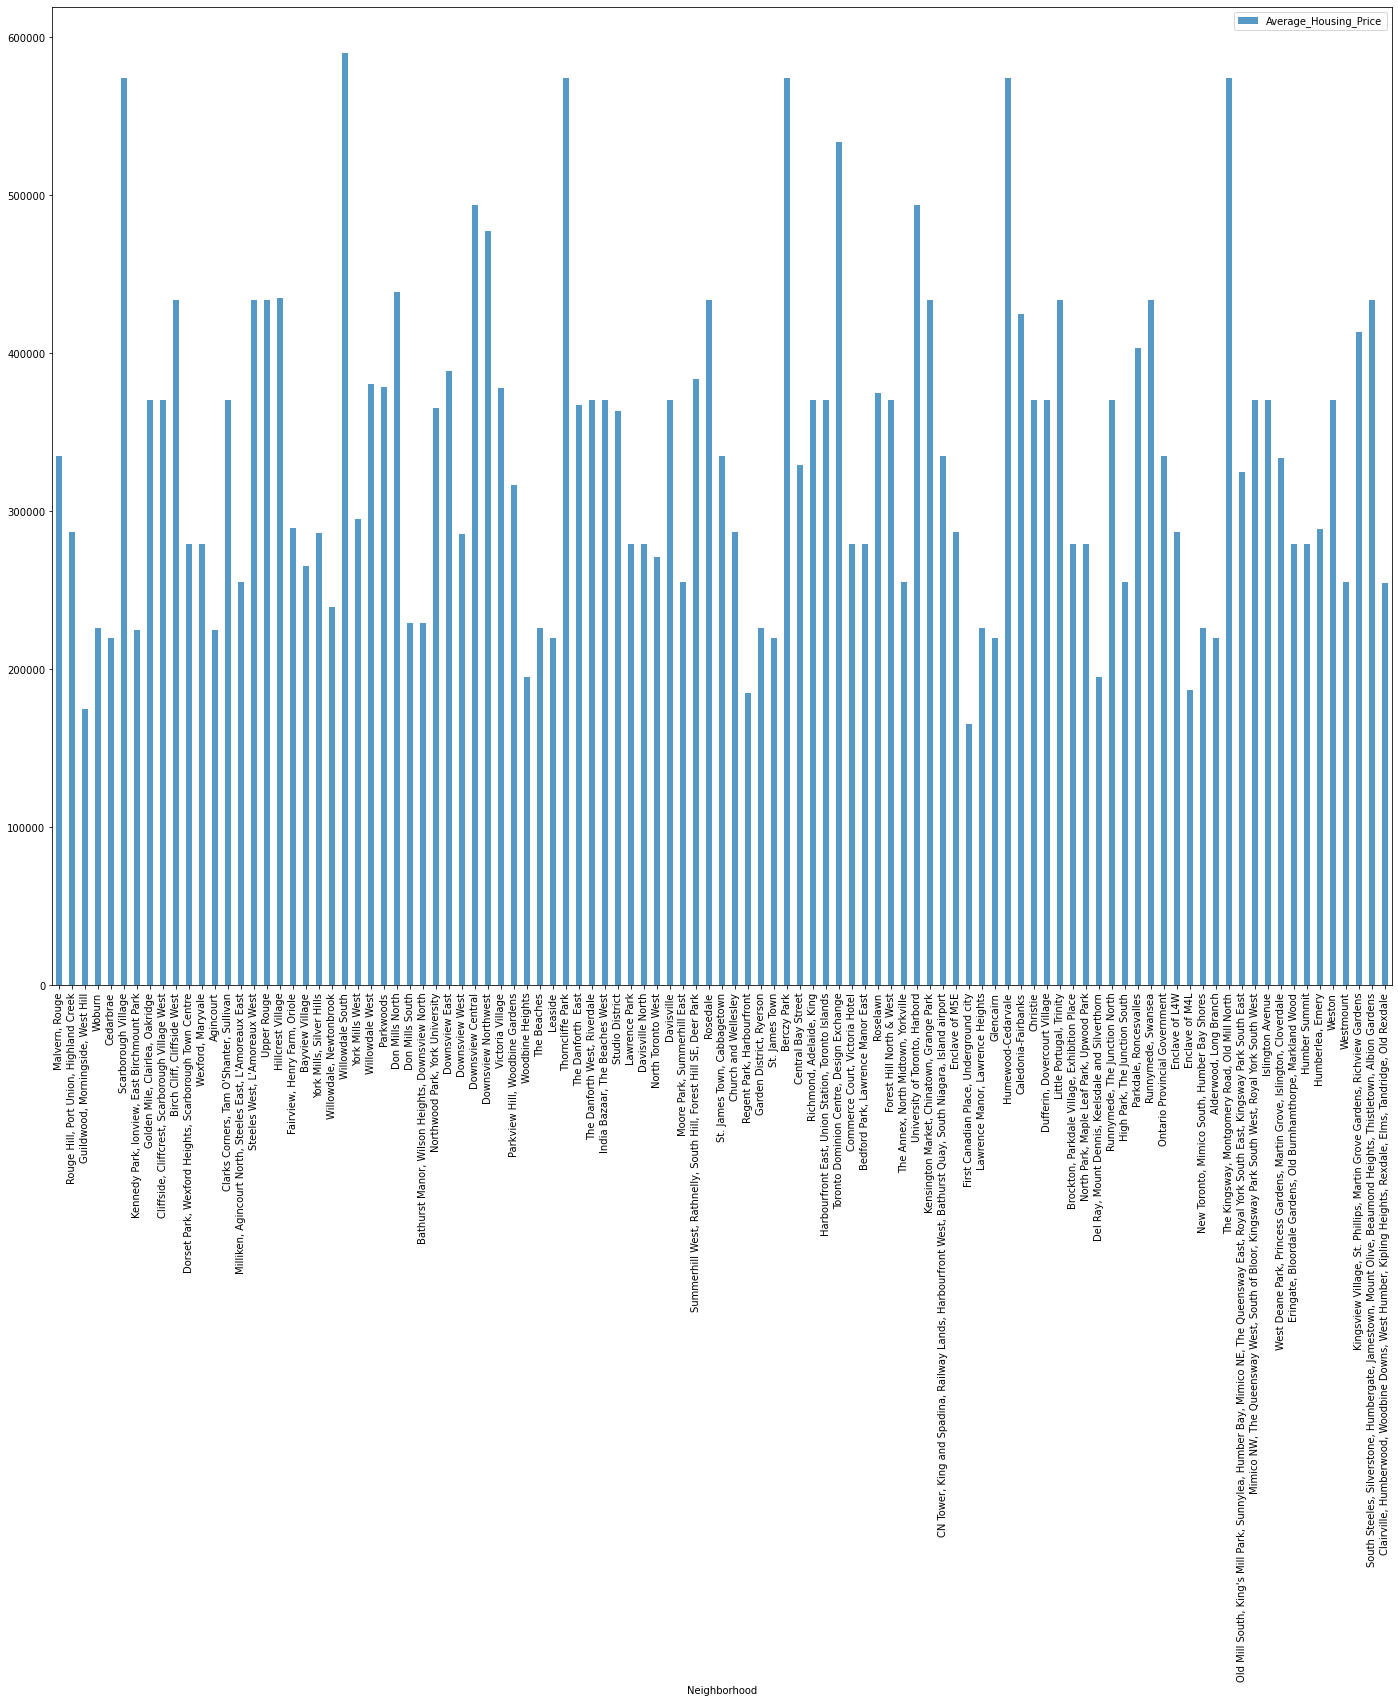

In [50]:
Downtown_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)

### IT Services Rating by Clusters

In [51]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [52]:
new_Downtown=Downtown_merged.set_index("Neighborhood",drop=True)

#Source:https://clutch.co/ca/it-services/msp/toronto
Downtown_it_services_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top IT Services Rating":[4.7,4.9,4.5,4.8,5,5,4.7,5,4.1,4.2,4.1,4.2,4.7,4.2,3.9,4.2,4.6,
                                                           4.5,4,4.8,4.9,4.9,4.6,4.6,4,4.5,4,4.6,4.8,5,4.8,4.9,4.6,4.2,
                                                           5,4.2,4.5,4.8,4.9,4.6,4.6,5,4.8,4.9,4.1,4.2,3.9,4,4.5,4.6,4.9,
                                                           4.8,4.5,4.9,4.6,4.9,4.6,4,4.8,5,4.2,4.5,4.6,3.9,4.9,4.8,4.7,
                                                           4.7,4.8,4.5,4.8,4.9,4.1,4.5,4,4.7,4.2,3.9,4.6,4.6,4.9,4,4.8,4.7,
                                                           4,4.8,4.9,4.2,4.6,4,4.7,4.5,5,4,4.6,4.8,4.9,4.7,4.5,4.6,4.5,4.8,4.7
                                                           ]})

In [53]:
Downtown_it_services_ratings.set_index('Neighborhood',inplace=True,drop=True)

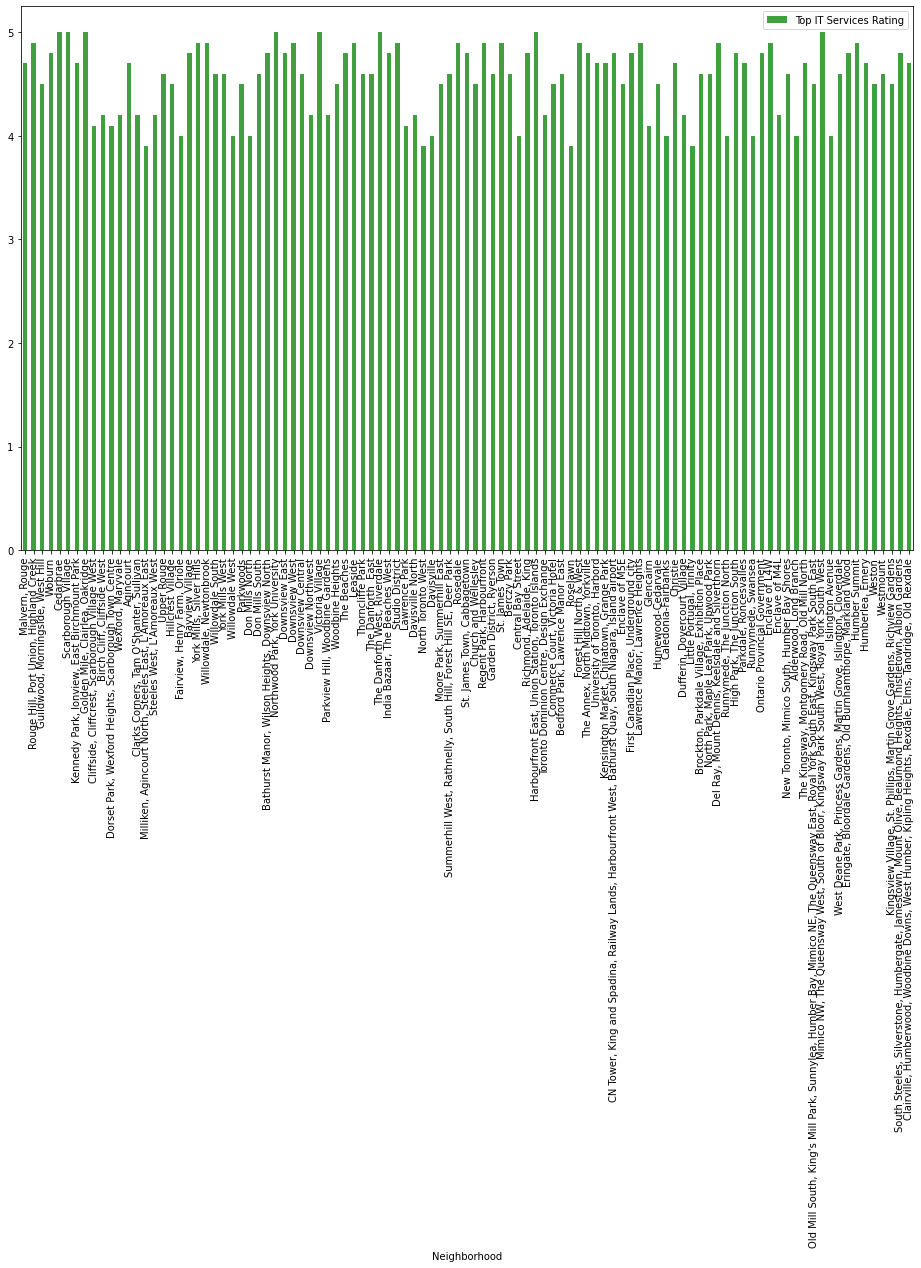

In [54]:
Downtown_it_services_ratings.plot(kind='bar',figsize=(16,10),color='green',alpha=0.75);

## 7) Conclusion

Conclusion: In this project, I used the k-means cluster algorithm to divide the neighbourhood into 10 different clusters and for 103 different latitude and longitude from a dataset with fairly comparable neighbourhoods. The above charts were used to deliver findings to a specific community based on typical house prices and school ratings.